In [21]:
import pandas as pd

df = pd.read_csv("accident_cleaned.csv")

df["ACCIDENT_TYPE_GROUPED"] = df["ACCIDENT_TYPE_DESC"].replace({
    "Collision with vehicle": "Collision",
    "Collision with a fixed object": "Collision",
    "collision with some other object": "Collision",
    "Struck Pedestrian": "Vulnerable Road User",
    "Struck animal": "Vulnerable Road User",
    "Vehicle overturned (no collision)": "Non-Collision",
    "No collision and no object struck": "Non-Collision",
    "Fall from or in moving vehicle": "Non-Collision"
})

df["IS_WEEKEND"] = df["DAY_WEEK_DESC"].isin(["Saturday", "Sunday"]).astype(int)

df["LIGHT_CONDITION_GROUPED"] = df["LIGHT_CONDITION"].replace({
    1: "Daylight",           
    5: "Twilight",           
    6: "Twilight",
    2: "Darkness",     
    3: "Darkness",
    4: "Darkness"
})

df["ROAD_GEOMETRY_GROUPED"] = df["ROAD_GEOMETRY_DESC"].replace({
    "Cross intersection": "Intersection",
    "T intersection": "Intersection",
    "Multiple intersection": "Intersection",
    "Y intersection": "Intersection",
    "Not at intersection": "Non-Intersection"
})

def categorize_speed(speed):
    if speed <= 40:
        return 'Very Low'
    elif speed <= 60:
        return 'Low'
    elif speed <= 80:
        return 'Medium'
    else:
        return 'High'
df["SPEED_ZONE_GROUPED"] = df["SPEED_ZONE"].apply(categorize_speed)

df["SURFACE_GROUPED"] = df["SURFACE_COND_DESC"].replace({
    "Dry": "Dry",
    "Wet": "Wet",
    "Icy": "Slippery",
    "Muddy": "Slippery",
    "Snowy": "Slippery"
})

df["ATMOSPH_GROUPED"] = df["ATMOSPH_COND_DESC"].replace({
    "Clear": "Clear",
    "Raining": "Rain/Snow",
    "Snowing": "Rain/Snow",
    "Strong winds": "Other Hazard",
    "Fog": "Other Hazard",
    "Dust": "Other Hazard",
    "Smoke": "Other Hazard"
})

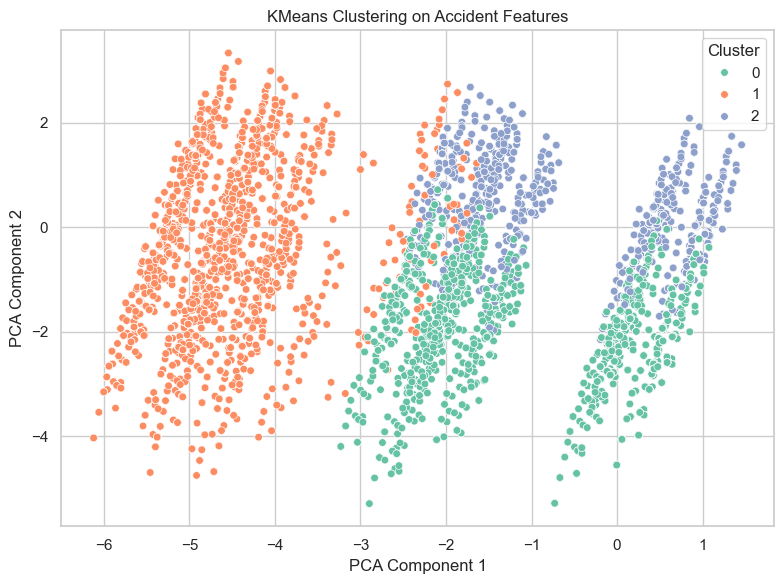

Cluster vs Severity Distribution (Proportion):
 SEVERITY         1         2         3
Cluster                               
0         0.025380  0.408182  0.566438
1         0.014696  0.364460  0.620845
2         0.011981  0.362873  0.625146
Cluster vs Severity Distribution (Count):
 SEVERITY     1      2      3
Cluster                     
0         1639  26360  36580
1          271   6721  11449
2          782  23684  40802


In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

# Select feature columns
features = [
    'ACCIDENT_TYPE_GROUPED', 'LIGHT_CONDITION_GROUPED', 'ROAD_GEOMETRY_GROUPED',
    'SPEED_ZONE_GROUPED', 'SURFACE_GROUPED', 'ATMOSPH_GROUPED', 'RMA', 'IS_WEEKEND'
]

# One-Hot
df_encoded = pd.get_dummies(df[features].astype(str))

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
plot_df["Cluster"] = clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=30)
plt.title("KMeans Clustering on Accident Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("figures/KMeans Clustering on Accident Features.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate proportional distribution
cluster_severity_ratio = pd.crosstab(df['Cluster'], df['SEVERITY'], normalize='index')
print("Cluster vs Severity Distribution (Proportion):\n", cluster_severity_ratio)
cluster_severity_count = pd.crosstab(df['Cluster'], df['SEVERITY'])
print("Cluster vs Severity Distribution (Count):\n", cluster_severity_count)


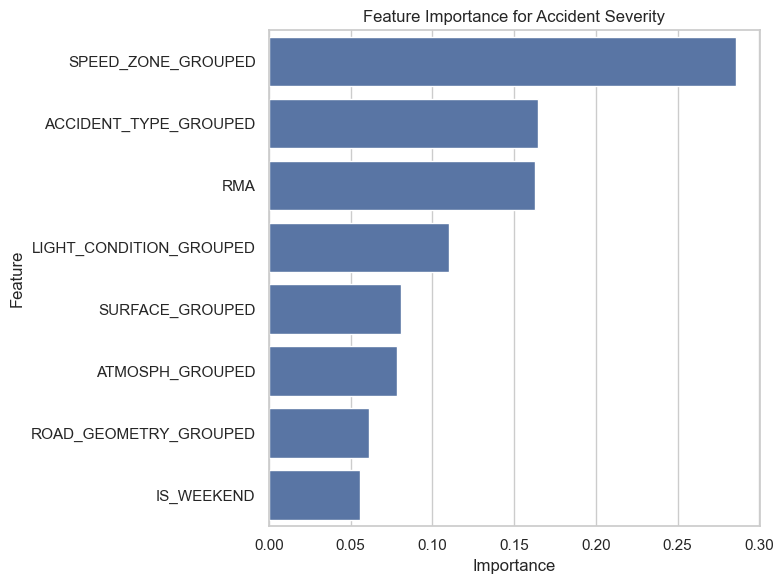

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    'ACCIDENT_TYPE_GROUPED', 'LIGHT_CONDITION_GROUPED', 'ROAD_GEOMETRY_GROUPED',
    'SPEED_ZONE_GROUPED', 'SURFACE_GROUPED', 'ATMOSPH_GROUPED', 'RMA', 'IS_WEEKEND'
]
X = df[features].copy()
y = df['SEVERITY']

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance for Accident Severity")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("figures/Feature Importance for Accident Severity.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1648\1354426152.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=data, x=feature, hue=target,


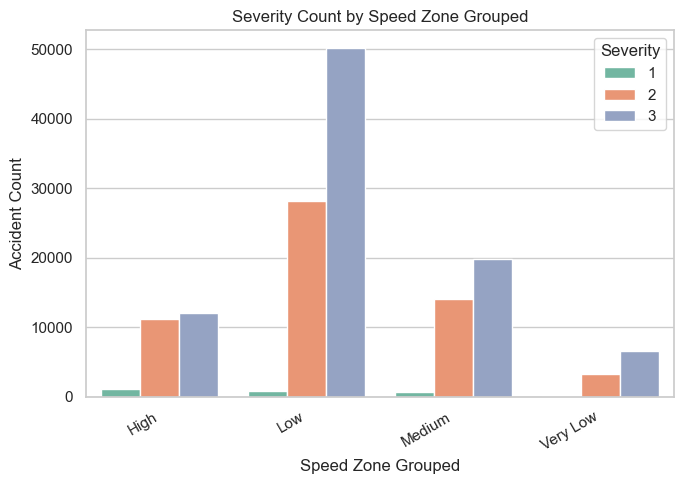

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1648\1354426152.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=data, x=feature, hue=target,


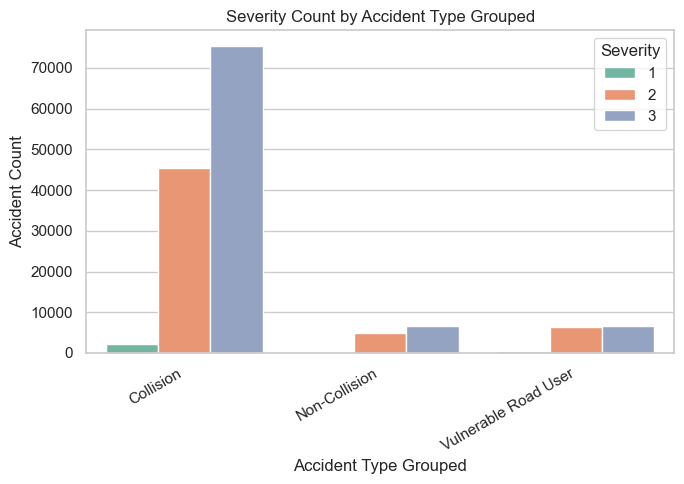

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1648\1354426152.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=data, x=feature, hue=target,


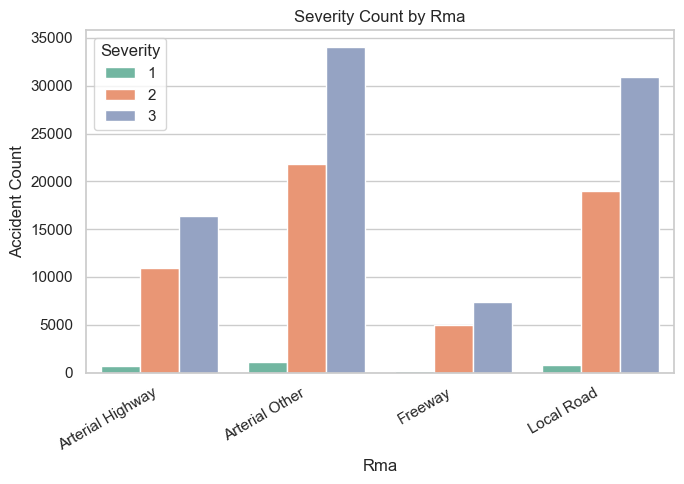

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1648\1354426152.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=data, x=feature, hue=target,


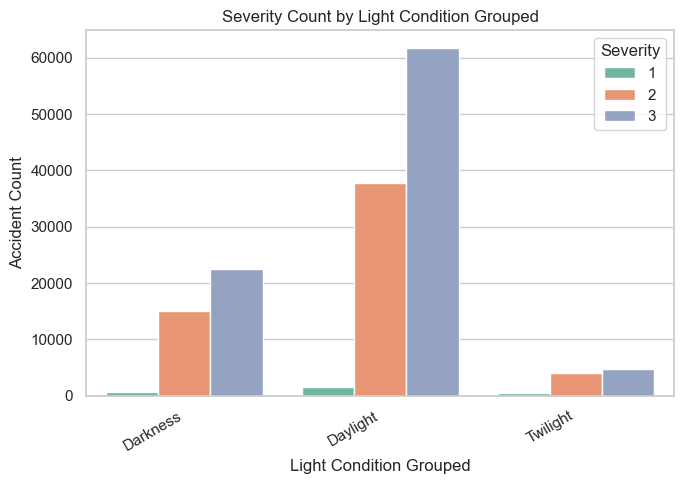

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1648\1354426152.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=data, x=feature, hue=target,


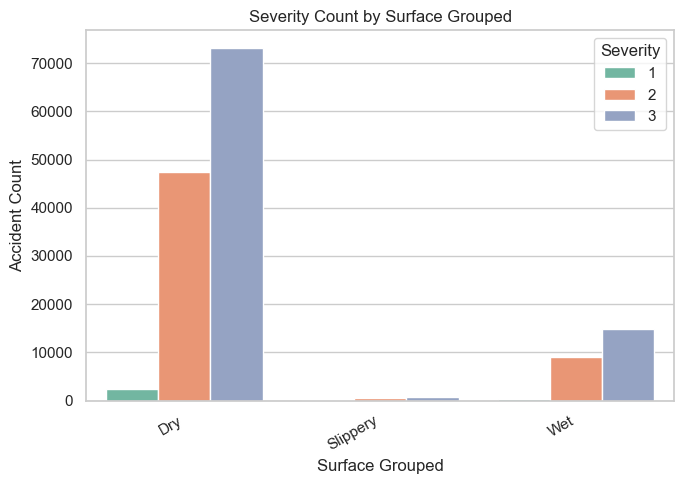

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style="whitegrid")
severity_order = [1, 2, 3]
palette = sns.color_palette("Set2")

output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

top_features = [
    'SPEED_ZONE_GROUPED',
    'ACCIDENT_TYPE_GROUPED',
    'RMA',
    'LIGHT_CONDITION_GROUPED',
    'SURFACE_GROUPED'
]

# Grouped histogram function
def plot_grouped_bar(data, feature, target='SEVERITY'):
    plt.figure(figsize=(7, 5))
    sns.countplot(data=data, x=feature, hue=target,
                  order=sorted(data[feature].unique()),
                  hue_order=severity_order, palette=palette)
    
    plt.title(f'Severity Count by {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Accident Count')
    plt.legend(title='Severity')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    filename = f"{output_dir}/Severity_by_{feature}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

for feature in top_features:
    plot_grouped_bar(df, feature)


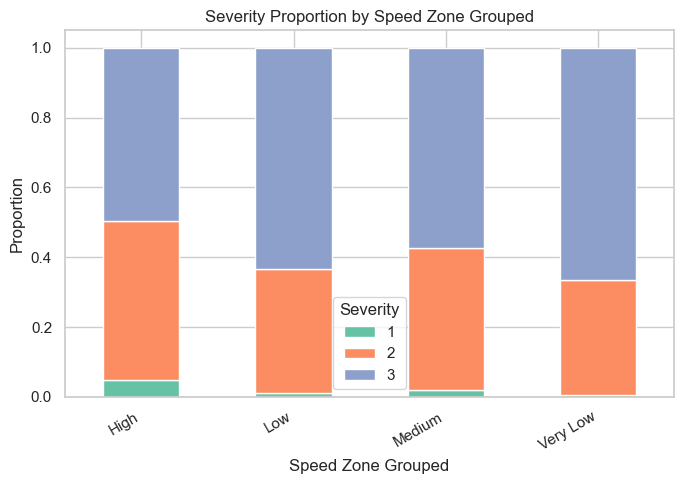

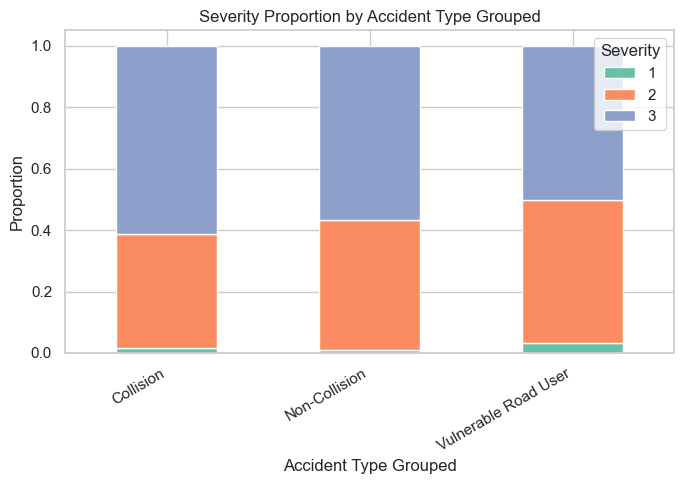

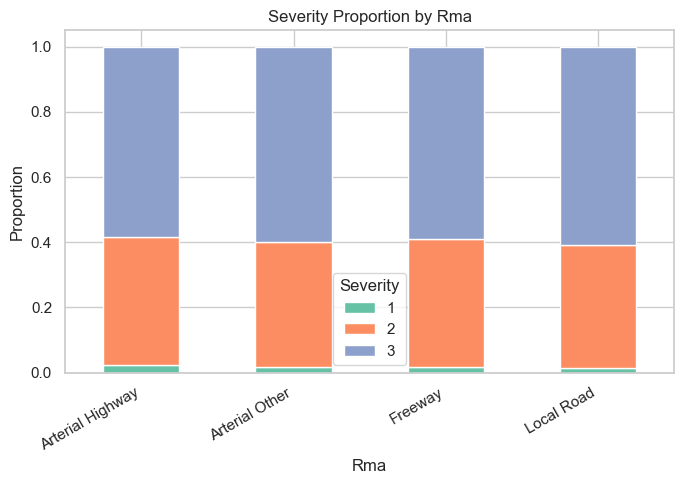

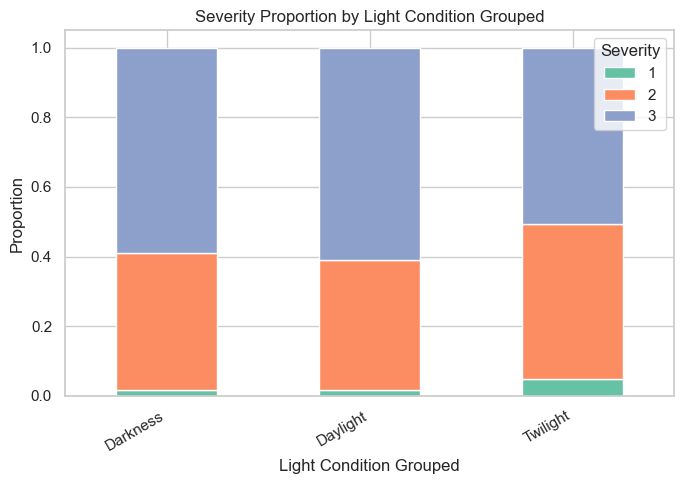

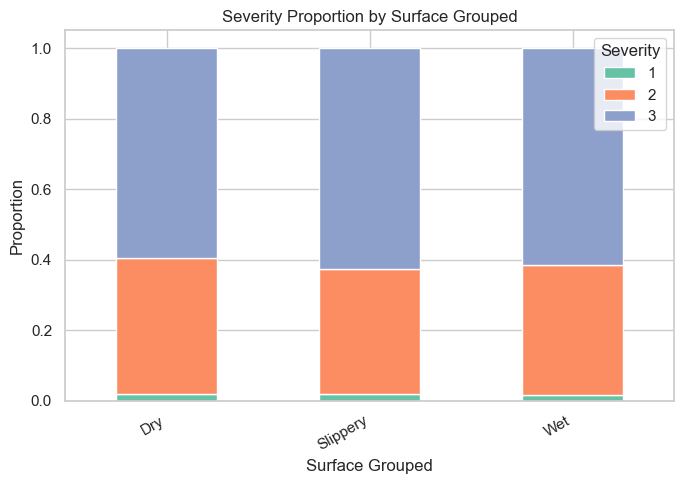

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
severity_order = [1, 2, 3]
severity_labels = ['1', '2', '3']
colors = sns.color_palette("Set2")

# Stacked Percentage Bar Chart
def plot_stacked_percentage_bar(df, feature, target='SEVERITY'):
    ctab = pd.crosstab(df[feature], df[target], normalize='index')[severity_order]
    ctab.plot(kind='bar', stacked=True, color=colors, figsize=(7, 5))

    plt.title(f'Severity Proportion by {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Proportion')
    plt.legend(title='Severity', labels=severity_labels)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    filename = f"{output_dir}/Stacked_Severity_by_{feature}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

top_features = [
    'SPEED_ZONE_GROUPED',
    'ACCIDENT_TYPE_GROUPED',
    'RMA',
    'LIGHT_CONDITION_GROUPED',
    'SURFACE_GROUPED'
]

for feature in top_features:
    plot_stacked_percentage_bar(df, feature)